In [1]:
from google.colab import drive
import os

drive.mount('/content/drive')
os.chdir("drive/MyDrive/VF2pp-in-CUDA/")
os.listdir()

Mounted at /content/drive


['LICENSE',
 'README.md',
 '.imp',
 '.tips',
 '.gitignore',
 'Makefile',
 '.git',
 'tmp',
 'data',
 'src',
 'vf2pp_sequential_O3',
 'vf2pp_sequential_O0',
 'vf2pp_sequential_O1',
 'vf2pp_parallel_O0',
 'vf2pp_sequential_O2',
 'vf2pp_parallel_O1',
 'vf2pp_parallel_O2',
 'vf2pp_parallel_O3',
 'benchmark']

CUDA SETUP

In [ ]:
!pip install nvcc4jupyter
!pip install pycuda

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 45.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 8.1 MB/s eta 0:00:00
  Created wheel for pycuda: filename=pycuda-2024.1.2-cp310-cp310-linux_x86_64.whl size=662246 sha256=6d165b1b0e17a03c75d1efd7f11fa341d44e6ed4c27107b4b3e7600886dc7e6a
  Stored in directory: /root/.cache/pip/wheels/70/63/40/4bf006182f942d3516b71bb2ff3b57ccbdb8b2c0ee81882b6e
Successfully built pycuda


GPU TYPE

In [ ]:
!nvidia-smi
!nvcc --version
%load_ext nvcc4jupyter

Sun Aug  4 09:17:49 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
import pycuda.driver as drv
import pycuda.autoinit
drv.init()
print("%d device(s) found." % drv.Device.count())
for i in range(drv.Device.count()):
  dev = drv.Device(i)
  print("Device #%d: %s" % (i, dev.name()))
  print(" Compute Capability: %d.%d" % dev.compute_capability())
  print(" Total Memory: %s GB" % (dev.total_memory() // (1024 * 1024 * 1024)))

1 device(s) found.
Device #0: Tesla T4
 Compute Capability: 7.5
 Total Memory: 14 GB


GPU INFO

In [ ]:
%%cuda

#include <stdio.h>
#include <stdlib.h>

void deviceQuery()
{
  cudaDeviceProp prop;
  int nDevices=0, i;
  cudaError_t ierr;

  ierr = cudaGetDeviceCount(&nDevices);
  if (ierr != cudaSuccess) { printf("Sync error: %s\n", cudaGetErrorString(ierr)); }



  for( i = 0; i < nDevices; ++i )
  {
     ierr = cudaGetDeviceProperties(&prop, i);
     printf("Device number: %d\n", i);
     printf("  Device name: %s\n", prop.name);
     printf("  Compute capability: %d.%d\n\n", prop.major, prop.minor);

     printf("  Clock Rate: %d kHz\n", prop.clockRate);
     printf("  Total SMs: %d \n", prop.multiProcessorCount);
     printf("  Shared Memory Per SM: %lu bytes\n", prop.sharedMemPerMultiprocessor);
     printf("  Registers Per SM: %d 32-bit\n", prop.regsPerMultiprocessor);
     printf("  Max threads per SM: %d\n", prop.maxThreadsPerMultiProcessor);
     printf("  L2 Cache Size: %d bytes\n", prop.l2CacheSize);
     printf("  Total Global Memory: %lu bytes\n", prop.totalGlobalMem);
     printf("  Memory Clock Rate: %d kHz\n\n", prop.memoryClockRate);


     printf("  Max threads per block: %d\n", prop.maxThreadsPerBlock);
     printf("  Max threads in X-dimension of block: %d\n", prop.maxThreadsDim[0]);
     printf("  Max threads in Y-dimension of block: %d\n", prop.maxThreadsDim[1]);
     printf("  Max threads in Z-dimension of block: %d\n\n", prop.maxThreadsDim[2]);

     printf("  Max blocks in X-dimension of grid: %d\n", prop.maxGridSize[0]);
     printf("  Max blocks in Y-dimension of grid: %d\n", prop.maxGridSize[1]);
     printf("  Max blocks in Z-dimension of grid: %d\n\n", prop.maxGridSize[2]);

     printf("  Warp size: %d\n\n", prop.warpSize);
     printf(" Constant Memory: %d\n", prop.totalConstMem);
     printf(" Max resident blocks per SM: %d\n", prop.maxBlocksPerMultiProcessor);
  }
}

int main() {
    deviceQuery();
}

Device number: 0
  Device name: Tesla T4
  Compute capability: 7.5

  Clock Rate: 1590000 kHz
  Total SMs: 40 
  Shared Memory Per SM: 65536 bytes
  Registers Per SM: 65536 32-bit
  Max threads per SM: 1024
  L2 Cache Size: 4194304 bytes
  Total Global Memory: 15835660288 bytes
  Memory Clock Rate: 5001000 kHz

  Max threads per block: 1024
  Max threads in X-dimension of block: 1024
  Max threads in Y-dimension of block: 1024
  Max threads in Z-dimension of block: 64

  Max blocks in X-dimension of grid: 2147483647
  Max blocks in Y-dimension of grid: 65535
  Max blocks in Z-dimension of grid: 65535

  Warp size: 32

 Constant Memory: 65536
 Max resident blocks per SM: 16



In [ ]:
!make clean
!make

CHOOSE THE BEST BLOCKSIZE ON RANDOM GRAPH OF DIFFERENT SIZES

In [ ]:
import os

graph_dimension = [3000, 5000, 8000, 10000]
blocksize = [64, 128, 256, 512]

for bs in blocksize:
    for dim in graph_dimension:
        cmd_parallel = f"./vf2pp_parallel_O0 {dim} 3 {bs}"
        !{cmd_parallel}


In [ ]:
'''
Each file name is of the type "result_{dim}_3.txt" so each file will contain 4 values, one for each blocksize used.
So each file represents the execution times on the graph of size "dim" with different blocksizes.
We begin by running the simulation, and then, for each blocksize, we calculate the average execution time across all dimensions of the graph.
The best one is 256 because it's the minimum average execution time across all dimensions. In addition, it has an occupancy of 25 percent.
'''

!mkdir -p ./benchmark/measures/blocksize
!mv ./benchmark/measures/parallel/* ./benchmark/measures/blocksize/

import os

def read_files(directory):
    measures = {0: [], 1: [], 2: [], 3: []}

    files = os.listdir(directory)

    for file in files:
        with open(os.path.join(directory, file), 'r') as f:
            line = f.read()
            times = line.split()
            for i, time in enumerate(times):
                measures[i].append(float(time))

    return measures

def calculate_means(measures):
    means = []

    for key, values in measures.items():
        mean = sum(values) / len(values)
        means.append(mean)

    return means

measures = read_files("./benchmark/measures/blocksize/")

means = calculate_means(measures)

import pandas as pd

data = {
    f"BLOCKSIZE {blocksize[0]}": [means[0]],
    f"BLOCKSIZE {blocksize[1]}": [means[1]],
    f"BLOCKSIZE {blocksize[2]}": [means[2]],
    f"BLOCKSIZE {blocksize[3]}": [means[3]],
}

df = pd.DataFrame(data, index=["Execution Time"])

output_directory = "./benchmark/measures/blocksize"
output_file = os.path.join(output_directory, "blocksize_means_results.csv")
df.to_csv(output_file)

print(df)

                BLOCKSIZE 64  BLOCKSIZE 128  BLOCKSIZE 256  BLOCKSIZE 512
Execution Time     20.718315      20.294913      20.048738      21.525348


CHOOSE THE BEST OPTIMIZATION ON RANDOM GRAPH OF DIFFERENT SIZES

In [ ]:
graph_dimension = [3000, 5000, 8000, 10000]
optimizations = ['O0','O1','O2','O3']

for opt in optimizations:
    for dim in graph_dimension:
        cmd_sequential = f"./vf2pp_sequential_{opt} {dim} 3"
        cmd_parallel = f"./vf2pp_parallel_{opt} {dim} 3 256"
        !{cmd_sequential}
        !{cmd_parallel}

In [ ]:
'''
Each file name is of the type "result_{dim}_3.txt" so each file will contain 4 values, one for each optimization performed.
So each file represents the execution times on the graph of size "dim" with different optimizations.
We begin by running the simulation, and then, for each optimization, we calculate the average execution time across all dimensions of the graph.
The best optimization is the O1 for both sequential and parallel versions with the optimal blocksize that's 256.
'''

!mkdir -p ./benchmark/measures/optimizations/sequential
!mkdir -p ./benchmark/measures/optimizations/parallel
!mv ./benchmark/measures/sequential/* ./benchmark/measures/optimizations/sequential/
!mv ./benchmark/measures/parallel/* ./benchmark/measures/optimizations/parallel/

import os

def read_files(directory):
    measures = {0: [], 1: [], 2: [], 3: []}

    files = os.listdir(directory)

    for file in files:
        with open(os.path.join(directory, file), 'r') as f:
            line = f.read()
            times = line.split()
            for i, time in enumerate(times):
                measures[i].append(float(time))

    return measures

def calculate_means(measures):
    means = []

    for key, values in measures.items():
        mean = sum(values) / len(values)
        means.append(mean)

    return means

seq_measures = read_files("./benchmark/measures/optimizations/sequential/")
par_measures = read_files("./benchmark/measures/optimizations/parallel/")

seq_means = calculate_means(seq_measures)
par_means = calculate_means(par_measures)

import pandas as pd

data = {
    "OPTIMIZATION 0": [seq_means[0], par_means[0]],
    "OPTIMIZATION 1": [seq_means[1], par_means[1]],
    "OPTIMIZATION 2": [seq_means[2], par_means[2]],
    "OPTIMIZATION 3": [seq_means[3], par_means[3]],
}

df = pd.DataFrame(data, index=["Sequential Means", "Parallel Means"])

output_directory = "./benchmark/measures/optimizations"
output_file = os.path.join(output_directory, "opt_means_results.csv")
df.to_csv(output_file)

print(df)


                  OPTIMIZATION 0  OPTIMIZATION 1  OPTIMIZATION 2  \
Sequential Means     1046.065460      551.812976      567.564568   
Parallel Means         19.479678       19.111196       19.600804   

                  OPTIMIZATION 3  
Sequential Means      678.450359  
Parallel Means         19.885869  


SPEEDUP ANALYSIS

SIMULATIONS ON SPARSE GRAPH OF DIFFERENT SIZES

In [ ]:
graph_dimension = [3000, 5000, 8000, 10000]

for _ in range(10):
    for dim in graph_dimension:
        cmd_sequential = f"./vf2pp_sequential_O1 {dim} 0"
        !{cmd_sequential}

!mkdir -p ./benchmark/measures/simulations_graphs/sparse/sequential
!mv ./benchmark/measures/sequential/* ./benchmark/measures/simulations_graphs/sparse/sequential/

In [ ]:
graph_dimension = [3000, 5000, 8000, 10000]

for _ in range(10):
    for dim in graph_dimension:
        cmd_parallel = f"./vf2pp_parallel_O1 {dim} 0 256"
        !{cmd_parallel}

!mkdir -p ./benchmark/measures/simulations_graphs/sparse/parallel
!mv ./benchmark/measures/parallel/* ./benchmark/measures/simulations_graphs/sparse/parallel/

SIMULATIONS ON DENSE GRAPH OF DIFFERENT SIZES

In [ ]:
graph_dimension = [3000, 5000, 8000, 10000]

for _ in range(10):
    for dim in graph_dimension:
        cmd_sequential = f"./vf2pp_sequential_O1 {dim} 1"
        !{cmd_sequential}

!mkdir -p ./benchmark/measures/simulations_graphs/dense/sequential
!mv ./benchmark/measures/sequential/* ./benchmark/measures/simulations_graphs/dense/sequential/

In [ ]:
graph_dimension = [3000, 5000, 8000, 10000]

for _ in range(10):
    for dim in graph_dimension:
        cmd_parallel = f"./vf2pp_parallel_O1 {dim} 1 256"
        !{cmd_parallel}

!mkdir -p ./benchmark/measures/simulations_graphs/dense/parallel
!mv ./benchmark/measures/parallel/* ./benchmark/measures/simulations_graphs/dense/parallel/

SIMULATIONS ON COMPLETE GRAPH OF DIFFERENT SIZES

In [ ]:
graph_dimension = [3000, 5000, 8000]

for _ in range(10):
    for dim in graph_dimension:
        cmd_sequential = f"./vf2pp_sequential_O1 {dim} 2"
        !{cmd_sequential}

!mkdir -p ./benchmark/measures/simulations_graphs/complete/sequential
!mv ./benchmark/measures/sequential/* ./benchmark/measures/simulations_graphs/complete/sequential/

In [ ]:
graph_dimension = [3000, 5000, 8000]

for _ in range(10):
    for dim in graph_dimension:
        cmd_parallel = f"./vf2pp_parallel_O1 {dim} 2 256"
        !{cmd_parallel}

!mkdir -p ./benchmark/measures/simulations_graphs/complete/parallel
!mv ./benchmark/measures/parallel/* ./benchmark/measures/simulations_graphs/complete/parallel/

SPEEDUP RESULTS

In [25]:
import matplotlib.pyplot as plt
import networkx as nx

class ParallelSequentialComparison:

    def __init__(self):
        self._nodes = []
        self._sequential_times = None
        self._parallel_times = None
        self._path = "./benchmark/measures/simulations_graphs"

    def reset(self):
        self._sequential_times = None
        self._parallel_times = None
        self._nodes.clear()

    def _extract_number(self, file_name):
        return int(file_name.split('_')[1])

    def _read_files(self, directory):
        directory = os.path.join(self._path, directory)

        times = []

        files = os.listdir(directory)
        files = sorted(files, key=self._extract_number)

        for file in files:
            self._nodes.append(self._extract_number(file)) if 'sequential' in directory else None
            with open(os.path.join(directory, file), 'r') as f:
                line = f.read()
                line = line.split()
                mean = sum([float(time) for time in line]) / len(line)
                times.append(float(mean))

        return times

    def plot_times(self):
      # Clear the figure to avoid overlap if this function is called multiple times
      plt.figure()

      # Plot sequential times with markers
      plt.plot(self._nodes, self._sequential_times, label="Sequential", linestyle="dashed", marker='o', color='blue')

      # Plot parallel times with markers
      plt.plot(self._nodes, self._parallel_times, label="Parallel", linestyle="solid", marker='o', color='orange')

      # Set the labels and title
      plt.xlabel("Graph Size")
      plt.ylabel("Time (seconds)")
      plt.title("Execution Time vs. Graph Size")
      plt.legend()

      # Annotate each point with its time value for sequential times
      for i, txt in enumerate(self._sequential_times):
          plt.annotate(f'{txt:.2f}', (self._nodes[i], self._sequential_times[i]), textcoords="offset points", xytext=(0,10), ha='center')

      # Annotate each point with its time value for parallel times
      for i, txt in enumerate(self._parallel_times):
          plt.annotate(f'{txt:.2f}', (self._nodes[i], self._parallel_times[i]), textcoords="offset points", xytext=(0,-15), ha='center')

      # Add grid for better readability
      plt.grid(True)

      # Display the plot
      plt.show()

    def plot_speedup(self):
        speedup = [seq_time / paral_time for seq_time, paral_time in zip(self._sequential_times, self._parallel_times)]
        plt.plot(self._nodes, speedup, marker='o')  # Add markers at each data point
        plt.xlabel("Graph Size")
        plt.ylabel("Speedup")
        plt.title("Speedup vs. Graph Size")

        # Annotate each point with its speedup value
        for i, txt in enumerate(speedup):
            plt.annotate(f'{txt:.2f}', (self._nodes[i], speedup[i]), textcoords="offset points", xytext=(0,10), ha='center')

        plt.grid(True)  # Optional: Add gridlines for better readability
        plt.show()

    def compare_in_complete_graphs(self):
        self.reset()
        self._sequential_times = self._read_files("complete/sequential")
        self._parallel_times = self._read_files("complete/parallel")

    def compare_in_dense_graphs(self):
        self.reset()
        self._sequential_times = self._read_files("dense/sequential")
        self._parallel_times = self._read_files("dense/parallel")

    def compare_in_sparse_graphs(self):
        self.reset()
        self._sequential_times = self._read_files("sparse/sequential")
        self._parallel_times = self._read_files("sparse/parallel")

SPEEDUP ON SPARSE GRAPH OF DIFFERENT SIZES

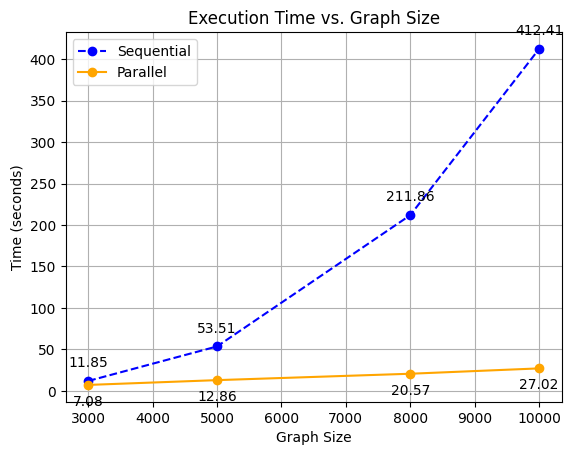

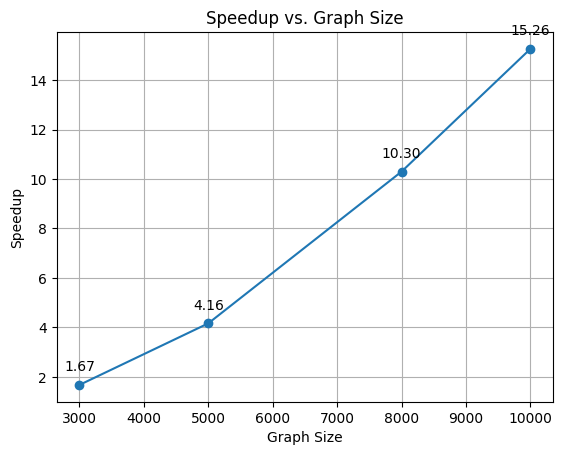

In [29]:
comp = ParallelSequentialComparison()
comp.compare_in_sparse_graphs()
comp.plot_times()
print("\n")
comp.plot_speedup()

SPEEDUP ON DENSE GRAPH OF DIFFERENT SIZES

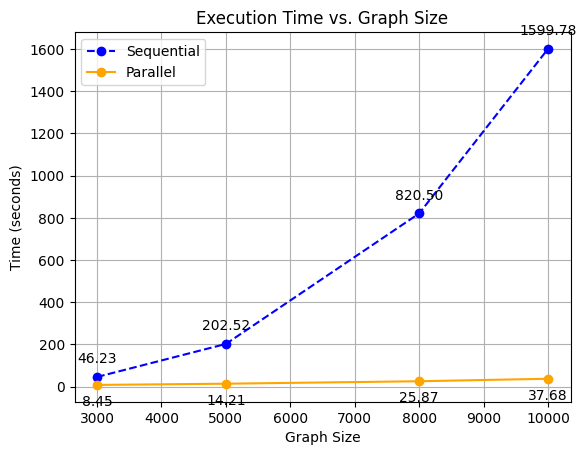

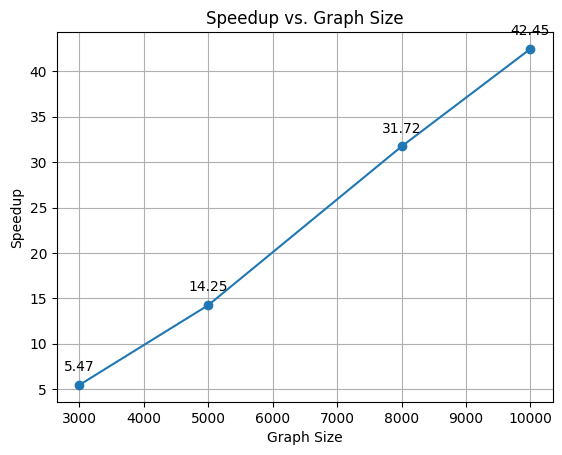

In [30]:
comp = ParallelSequentialComparison()
comp.compare_in_dense_graphs()
comp.plot_times()
print("\n")
comp.plot_speedup()

SPEEDUP ON COMPLETE GRAPH OF DIFFERENT SIZES

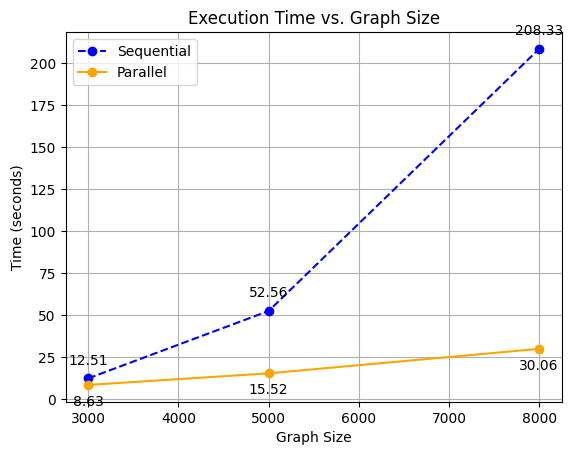

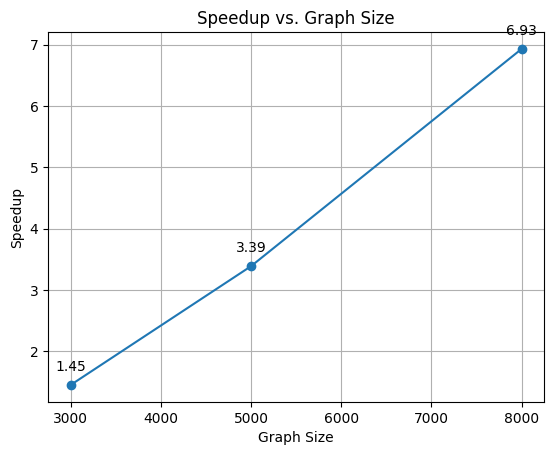

In [31]:
comp = ParallelSequentialComparison()
comp.compare_in_complete_graphs()
comp.plot_times()
print("\n")
comp.plot_speedup()